##### *Import required libraries from* **requirements_01.txt**

In [3]:
%pip install -r requirements_01.txt

Note: you may need to restart the kernel to use updated packages.


##### *Import required libraries from* **requirements_02.txt**

In [7]:
%pip install -r requirements_02.txt

Note: you may need to restart the kernel to use updated packages.


##### *Upgrade* **torchvision** *library*

In [6]:
%pip install --upgrade torch torchvision

  Using cached torch-2.0.1-cp310-cp310-win_amd64.whl (172.3 MB)
  Using cached torchvision-0.15.2-cp310-cp310-win_amd64.whl (1.2 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ADMIN\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\torch\\~-b\\asmjit.dll'
Check the permissions.



In [11]:
%pip install torchviz

Note: you may need to restart the kernel to use updated packages.


In [22]:
%pip install pytorch_model_summary

Note: you may need to restart the kernel to use updated packages.


##### *Import all required libraries*

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as T
from torchvision import models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchviz import make_dot
from pytorch_model_summary import summary

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from tqdm import tqdm
%matplotlib inline

##### *Set directory path for images lying inside* **training** *directory as well as in* **testing** *directory dataset.*

##### *Calculate total number of images lying inside* **training** *directory*

In [3]:
#path of training dataset
train_path = './imgs/training_data/'

#path of testing dataset
test_path = './imgs/testing_data/'

train_length = 0
for clas in os.listdir(train_path):
    train_length += len(os.listdir(os.path.join(train_path, clas)))

##### **Transform** *and* **augment** *all images of* **training** *dataset through* **resizing** *as well as* **slight adjustment** *in color and brightness*

In [3]:
# Data Transforms and Augmentation
train_transforms = T.Compose([T.Resize((64, 64)),
    T.RandomAdjustSharpness(2),
    T.RandomRotation((-15, 15)),
    T.ColorJitter(brightness = 0.5, hue = 0.3),
    T.ToTensor()
])

##### *Load modified data from the* **training** *dataset directory using* **ImageFolder** *function*

In [4]:
# Loading Data using ImageFolder
train_ds = ImageFolder(train_path, train_transforms)
classes = train_ds.classes

##### *Split your dataset into two different sets i.e.,* **training (90%)** *and* **validation (10%)** *sets.*

In [5]:
# Splitting into train-val set
val_pct = 0.1
val_size = int(val_pct *len(train_ds))
train_ds, valid_ds = random_split(train_ds, [len(train_ds) - val_size, val_size])

##### *Let's set the* **data loaders** *which efficiently loads and processes training and validation data in batches during model training.*

##### **Note:** *The* **batch size** *determines how many samples are processed together, and other parameters like shuffling the data, using multiple worker processes and pinning memory can improve data loading performance and training efficiency.*

In [6]:
# Data Loader
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers = 2, pin_memory = True)

##### *Define* **ResNet34** *model generate corresponding* **layered architecture.**

In [8]:
class ResNet34(nn.Module):
    def __init__(self, num_classes, pretrained = True):
        super().__init__()
        
        # Use a pretrained model
        self.network = models.resnet34(pretrained = pretrained)

        # Replace Last Layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
  
    def forward(self, x):
        return self.network(x)
    
# Create an instance of ResNet34
model = ResNet34(num_classes = 500, pretrained = True)

# Define the scaling factor
scaling_factor = 0.01

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 224, 224) * scaling_factor

# Generate the visualization graph
output = model(dummy_input)

# Specify the path to the Graphviz executable
os.environ['PATH'] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# Generate the visualization graph with the specified path
dot = make_dot(output, params = dict(model.named_parameters()))

# Save the graph as a PNG file
dot.format = 'png'
dot.render('resnet34_graph', view = False)

'resnet34_graph.png'

##### *Check whether* **CUDA-enabled GPU** *(Graphics Processing Unit) is available for use with the* **PyTorch** *library.*

In [9]:
# Device configuration
if torch.cuda.is_available(): 
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

##### *Configure your* **pretrained model** *with a specified number of output classes.*

In [10]:
# Model configuration
pretrained_model = ResNet34(num_classes = 10)

##### *Project your* **pretrained** *model to a specific device i.e., either a* **GPU** *or* **CPU** *for execution*

In [11]:
pretrained_model.to(device)

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

##### *Let's set the parameters for training a* **neural network** *model.*

In [12]:
# Setting parameters
epochs, lr = 8, 1e-4
opt_func = torch.optim.Adam

##### *Define a function named* **accuracy** *that calculates the accuracy of a* **model's predictions** *given the predicted outputs and the corresponding labels.* 

In [13]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

##### *Define a function named* **evaluate** *that evaluates the* **performance** *of a model on a* **validation** *dataset.*

In [14]:
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        images, labels = batch
        images = images.to(device)
        out = model(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        outputs.append({
            'val_loss': loss.detach(), 
            'val_acc': acc
        })
    
    batch_losses = [x['val_loss'] for x in outputs]

    # Combine Losses
    epoch_loss = torch.stack(batch_losses).mean() 
    batch_accs = [x['val_acc'] for x in outputs]

    # Combine Accuracies 
    epoch_acc = torch.stack(batch_accs).mean() 
    return {
        'val_loss': epoch_loss.item(),
        'val_acc': epoch_acc.item()
    }

##### *Let's set up a* **custom optimizer** *with weight decay for a pretrained model.*

In [15]:
# Set up custom optimizer with weight decay
optimizer = opt_func(pretrained_model.parameters(), lr)

In [34]:
%pip install ipywidgets

In [35]:
%pip install numpy==1.24.1

Note: you may need to restart the kernel to use updated packages.


##### **Training** *and* **evaluating** *a pretrained model for multiple epochs while saving the results for later evaluation and comparison.*

In [16]:
# Saving results for the evaluation of the model and comparison with other model
history = []

for epoch in range(epochs):
  #Training Phase
  pretrained_model.train()
  train_losses = []
  y_true = []
  y_pred = []
  
  # Counter for correct predictions
  train_correct = 0  
    
  # Counter for total predictions
  train_total = 0  
  lrs = []
  
  for batch in tqdm(train_dl):
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    out = pretrained_model(images)
    loss = F.cross_entropy(out, labels)
    train_losses.append(loss)  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Count correct predictions
    _,predicted = torch.max(out.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

  # Calculate accuracy
  train_accuracy = train_correct / train_total

  # Validation Phase
  result = evaluate(pretrained_model, valid_dl)
  result['train_loss'] = torch.stack(train_losses).mean().item()

  # Add train accuracy to the result dictionary
  result['train_acc'] = train_accuracy  
  print('Epoch [{}/{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
    epoch, epochs, 
    result['train_loss'], result['train_acc'], 
    result['val_loss'], result['val_acc']
  ))

  history.append(result) 

100%|██████████| 246/246 [10:57<00:00,  2.67s/it]


Epoch [0/8], train_loss: 0.7381, train_acc: 0.7558, val_loss: 0.1779, val_acc: 0.9405


100%|██████████| 246/246 [12:54<00:00,  3.15s/it]


Epoch [1/8], train_loss: 0.1395, train_acc: 0.9557, val_loss: 0.0882, val_acc: 0.9740


100%|██████████| 246/246 [09:34<00:00,  2.33s/it]


Epoch [2/8], train_loss: 0.0739, train_acc: 0.9777, val_loss: 0.0722, val_acc: 0.9835


100%|██████████| 246/246 [08:43<00:00,  2.13s/it]


Epoch [3/8], train_loss: 0.0610, train_acc: 0.9813, val_loss: 0.0566, val_acc: 0.9846


100%|██████████| 246/246 [1:51:59<00:00, 27.32s/it]     


Epoch [4/8], train_loss: 0.0520, train_acc: 0.9839, val_loss: 0.0605, val_acc: 0.9846


100%|██████████| 246/246 [1:22:15<00:00, 20.06s/it]    


Epoch [5/8], train_loss: 0.0437, train_acc: 0.9864, val_loss: 0.0624, val_acc: 0.9857


100%|██████████| 246/246 [45:14<00:00, 11.03s/it]   


Epoch [6/8], train_loss: 0.0309, train_acc: 0.9920, val_loss: 0.0528, val_acc: 0.9880


100%|██████████| 246/246 [46:54<00:00, 11.44s/it]   


Epoch [7/8], train_loss: 0.0237, train_acc: 0.9927, val_loss: 0.0461, val_acc: 0.9908


##### *Let's save the state and the entire pretrained model to a disk.*

In [17]:
torch.save(pretrained_model.state_dict(), './learning_models/armor_resnet34.pth')
torch.save(pretrained_model, './learning_models/model.pth')

##### *Evaluating a* **pretrained model** *on a* **validation dataset** *and printing the evaluation results.*

In [18]:
result = evaluate(pretrained_model, valid_dl)
print(result)

{'val_loss': 0.045849673449993134, 'val_acc': 0.9879712462425232}


#### *Now, we'll visualize the* **accuracy** *and* **loss** *gained by the* **pretrained model**

In [19]:
# Extracting values from history
train_losses = [result['train_loss'] for result in history]
train_accs = [result['train_acc'] for result in history]  

val_losses = [result['val_loss'] for result in history]
val_accs = [result['val_acc'] for result in history]

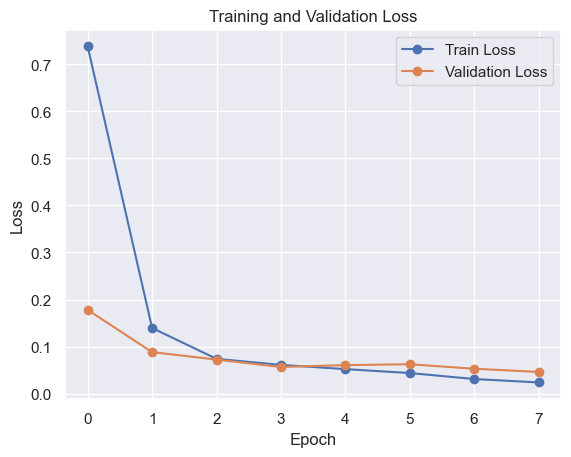

In [32]:
# Plotting the loss graph
sns.set(style = 'darkgrid')

plt.plot(train_losses, label = 'Train Loss', marker = 'o')
plt.plot(val_losses, label = 'Validation Loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

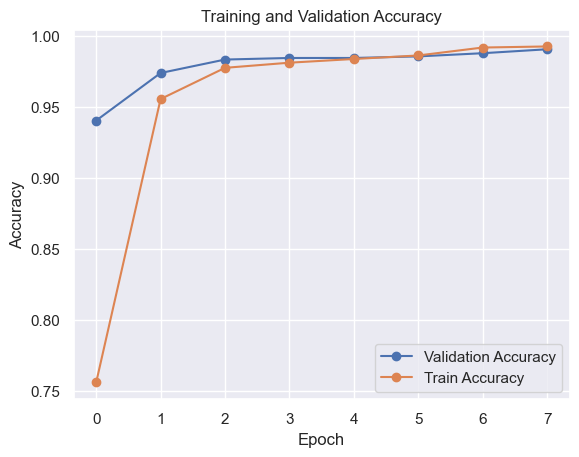

In [40]:
# Plotting the accuracy graph
sns.set(style = 'darkgrid')

plt.plot(val_accs, label = 'Validation Accuracy', marker = 'o')
plt.plot(train_accs, label = 'Train Accuracy', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Generate confusion matrix
confusion_mat = metrics.confusion_matrix(y_true, y_pred)

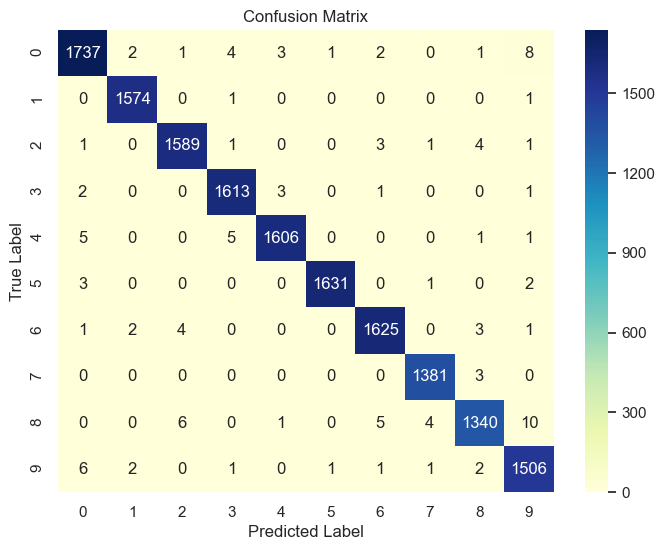

In [38]:
# Plotting the confusion matrix using seaborn
plt.figure(figsize = (8, 6))
sns.heatmap(confusion_mat, annot = True, fmt = 'd', cmap = 'YlGnBu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()